Mounted at /content/drive
1/1 [==============================] - 5s 5s/step


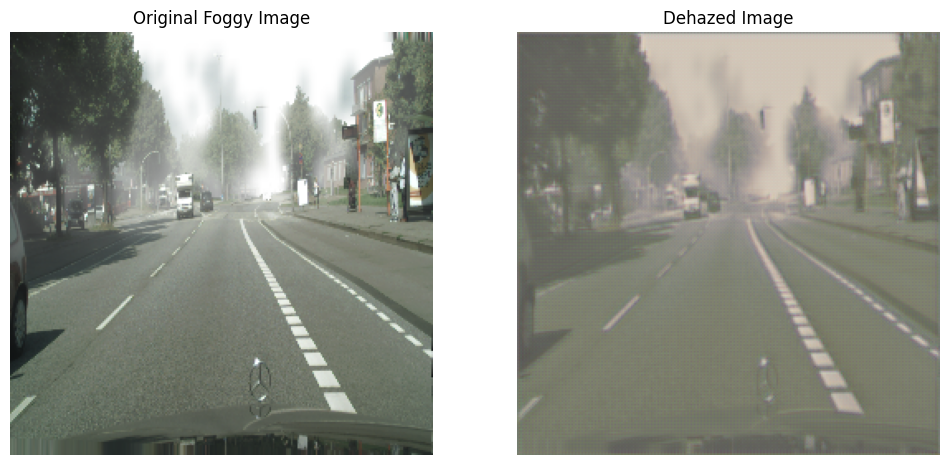

1/1 [==============================] - 2s 2s/step


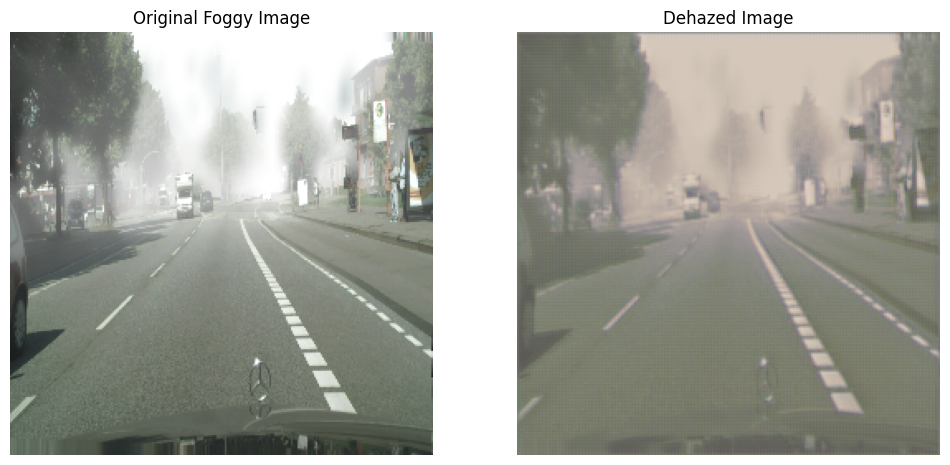

1/1 [==============================] - 2s 2s/step


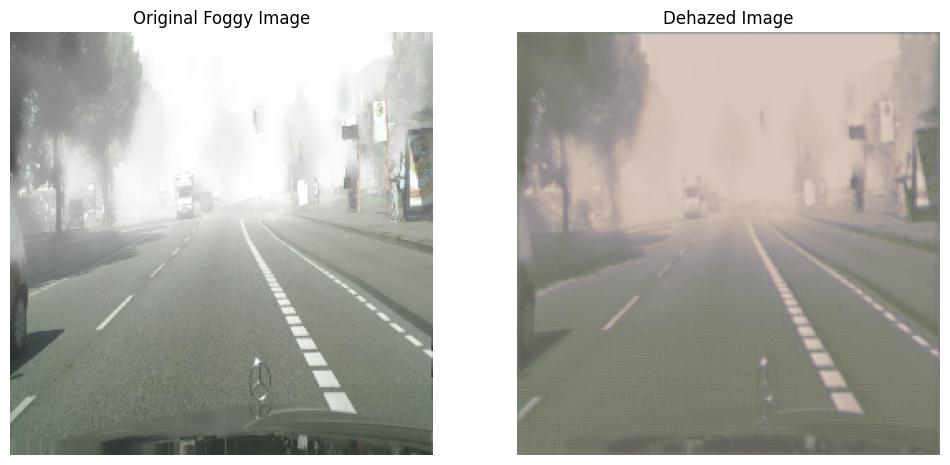

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.image import psnr, ssim
from tensorflow.keras.utils import register_keras_serializable

# Google Drive mounting
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Define the PSNR and SSIM metrics
@register_keras_serializable()
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

@register_keras_serializable()
def ssim_metric(y_true, y_pred, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03):
    return tf.image.ssim(y_true, y_pred, max_val=max_val, filter_size=filter_size, filter_sigma=filter_sigma, k1=k1, k2=k2)

# Load VGG19 for perceptual loss
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
output_layer = vgg.get_layer('block2_conv2').output
vgg_model = Model(inputs=vgg.input, outputs=output_layer)

@register_keras_serializable()
def perceptual_loss(y_true, y_pred):
    vgg_true = vgg_model(y_true)
    vgg_pred = vgg_model(y_pred)
    return K.mean(K.square(vgg_true - vgg_pred))

# Mean Squared Error loss
mse_loss = MeanSquaredError()

@register_keras_serializable()
def custom_loss(y_true, y_pred):
    mse = mse_loss(y_true, y_pred)
    p_loss = perceptual_loss(y_true, y_pred)
    mse = tf.cast(mse, 'float32')
    p_loss = tf.cast(p_loss, 'float32')
    return mse + p_loss

# Custom objects dictionary
custom_objects = {
    "custom_loss": custom_loss,
    "psnr_metric": psnr_metric,
    "ssim_metric": ssim_metric,
    "perceptual_loss": perceptual_loss
}

# Load the model with custom objects
model_path = '/content/drive/My Drive/diss/myproj/results/3_6VGG19LossMSEModResFog.keras'
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Define paths to images and results
image_paths = [
    "/content/drive/My Drive/diss/myproj/data_test/test/hamburg_000000_000042_leftImg8bit_foggy_beta_0.005.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/hamburg_000000_000042_leftImg8bit_foggy_beta_0.01.png",
    "/content/drive/My Drive/diss/myproj/data_test/test/hamburg_000000_000042_leftImg8bit_foggy_beta_0.02.png",
    # Add other image paths as required
]
save_paths = [
    "/content/drive/My Drive/diss/myproj/results/images/hamburg_000000_000042_leftImg8bit_foggy_beta_0.005.png",
    "/content/drive/My Drive/diss/myproj/results/images/hamburg_000000_000042_leftImg8bit_foggy_beta_0.01.png",
    "/content/drive/My Drive/diss/myproj/results/images/hamburg_000000_000042_leftImg8bit_foggy_beta_0.02.png",
    # Add other save paths as required
]

# Process each image
for image_path, save_path in zip(image_paths, save_paths):
    foggy_image = load_img(image_path, target_size=(256, 256))
    foggy_image_array = img_to_array(foggy_image) / 255.0
    foggy_image_array = np.expand_dims(foggy_image_array, axis=0)  # Add batch dimension
    dehazed_image_array = model.predict(foggy_image_array)
    dehazed_image = dehazed_image_array[0]  # Remove batch dimension
    save_img(save_path, dehazed_image * 255.0)  # Save the dehazed image

    # Plot results for visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(foggy_image_array[0])
    plt.title("Original Foggy Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(dehazed_image)
    plt.title("Dehazed Image")
    plt.axis('off')
    plt.show()
